## <font color=darkorange> Gradient descent algorithms. Application to logistic regression</font>

In [10]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
# Required packages
np.set_printoptions(precision=2) 
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn
from numpy.linalg import norm
from scipy.optimize import check_grad
import seaborn as sns

## <font color=darkred>Logistic regression </font>

### <font color=darkred>  Model </font>

$\rightharpoondown$ The objective is to predict the  label $Y\in\{0,1\}$ based on $X\in\mathbb{R}^d$.

$\rightharpoondown$ Logistic regression models the distribution of $Y$ given $X$.

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(\langle w,X \rangle + b)\,,
\end{equation*}
where $w \in \mathbb{R}^d$ is a vector of model weights and $b \in \mathbb{R}$ is the intercept, and where $\sigma$ is the sigmoid function.

$$
\sigma: z \mapsto \frac{1}{1 + e^{-z}}\,.
$$

$\rightharpoondown$ The sigmoid function is a \alert{model choice to map $\mathbb{R}$ into $(0,1)$}.

In [13]:
def sigmoid(x):
    expx = np.exp(x)
    z   = expx / (1. + expx)
    return z

def sample_logistic(w0, n_samples=1000, corr=0.5):
    n_features = w0.shape[0]
    cov        = toeplitz(corr ** np.arange(0, n_features))
    X          = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p          = sigmoid(X.dot(w0))
    y          = np.random.binomial(1, p, size=n_samples)
    return X, y

<font color=darkred>  Prove that the Bayes classifier is linear in the logistic regression setting</font>

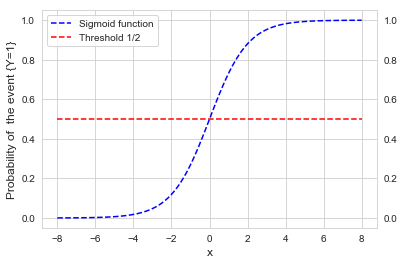

In [14]:
x = np.linspace(-8,8,100)
z = sigmoid(x)
plt.plot(x,z,linestyle = "dashed",color="blue", label= "Sigmoid function")
plt.plot(x,.5*np.ones(np.size(x)),linestyle = "dashed",color="red", label="Threshold 1/2")
plt.ylabel('Probability of  the event {Y=1}', fontsize=12)
plt.xlabel('x', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')
plt.legend();

Logistic regression models the distribution of $Y$ given $X$.

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(\langle w,X \rangle + b)\,,
\end{equation*}

The graph above illustrates that the Bayes classification rule in this case is
$f^*(X) = 1$ if and only if $\langle w,X \rangle + b>0$.

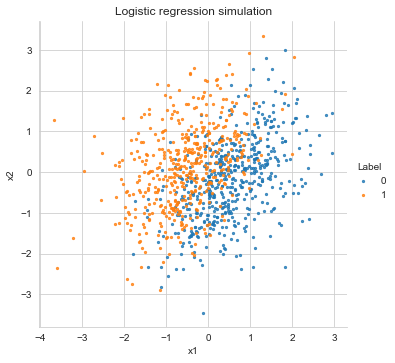

In [15]:
n_samples  = 1000
n_features = 2

w0   = multivariate_normal([-2,1], np.eye(2))

X, y = sample_logistic(w0, n_samples=n_samples, corr = 0.3)

simulated_data          = pd.DataFrame(columns = ["x","y","Label"])
simulated_data["x1"]     = X[:,0]
simulated_data["x2"]     = X[:,1]
simulated_data["Label"] = y

sns.set_style("whitegrid")
sns.lmplot(x = "x1", y = "x2", data = simulated_data, fit_reg = False, hue = "Label", legend = True, scatter_kws={"s": 5})

plt.title("Logistic regression simulation");

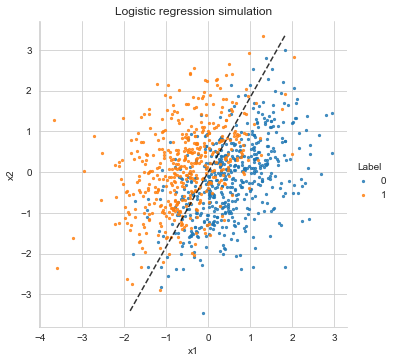

In [16]:
def decision_function(X,w):
    z = sigmoid(X.dot(w))
    return z
    
xlim  = [np.min(X[:,0]), np.max(X[:,0])]
ylim  = [np.min(X[:,1]), np.max(X[:,1])]
xplot = np.linspace(xlim[0], xlim[1], 30)
yplot = np.linspace(ylim[0], ylim[1], 30)

Yplot, Xplot = np.meshgrid(yplot, xplot)
xy           = np.vstack([Xplot.ravel(), Yplot.ravel()]).T
P            = decision_function(xy,w0).reshape(Xplot.shape)

sns.set_style("whitegrid")
sns.lmplot(x = "x1", y = "x2", data = simulated_data, fit_reg = False, hue = "Label", legend = True, scatter_kws={"s": 5})

plt.title("Logistic regression simulation");

# plot decision boundary and margins
plt.contour(Xplot, Yplot, P, colors = 'k', levels = [0.5], alpha = 0.8, linestyles = ['--']);

### <font color=darkred>  Logistic regression: losses and gradients </font>

The aim of this section is to detail how to solve the following optimization problem
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}\,,
$$
where $d$ is the number of features.

$$
f: w \mapsto \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \{-y_ix_i'w + \log(1 + \exp(x_i' w))\} + \frac{\lambda}{2} \|w\|_2^2\,,
$$
where $n$ is the sample size, and where $y_i \in \{ 0, 1 \}$ for all $1\leqslant i\leqslant n$.
 
A basic gradient descent algorithm requires to compute the functions $f$ and $\nabla f$.

<font color=darkred>  Write the likelihood of the logistic regression model and its gradient (blackboard)</font>

In [29]:
class LogisticRegression:
    def __init__(self, X, y, lmbd):
        self.X = X
        self.y = y
        self.lmbd = lmbd
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        # Computes f(w)
        y, X, n_samples, lmbd = self.y, self.X, self.n_samples, self.lmbd
        res = 0
        for k in range(n_samples):
            res += np.log(1+np.exp(X[k].dot(w))) - y[k]*X[k].dot(w)
        res = res/n_samples
        res += lmbd*0.5*(norm(w)**2)
        return res
    
    def grad(self, w):
        # Computes the gradient of f at w
        y, X, n_samples, lmbd = self.y, self.X, self.n_samples, self.lmbd
        res = 0
        for k in range(n_samples):
            res += -y[k]*X[k] + np.exp(X[k].dot(w))/(1+np.exp(X[k].dot(w)))*X[k]
        res = res/n_samples
        res += lmbd*w
        return res  
    
    def grad_fi(self, i, w):
        # Computes the gradient of f_i at w
        x_i = self.X[i]
        return -y[i]*x_i + np.exp(x_i.dot(w))/(1+np.exp(x_i.dot(w)))*x_i + self.lmbd * w

    def grad_coordinate(self, j, w):
        # Computes the partial derivative of f with respect to the j-th coordinate
        y, X, n_samples, lmbd = self.y, self.X, self.n_samples, self.lmbd
        return X[:, j].T.dot(X.dot(w) - y) / n_samples + lmbd* w[j]

In [32]:
# Check numerically the gradient using the function checkgrad from scipy.optimize
# Use the function simu_logreg to simulate data according to the logistic regression model
n_features = 10
w_true     = np.random.randn(n_features)
X, y       = sample_logistic(w_true, n_samples, corr=0.9)
model      = LogisticRegression(X, y, 1e-3)
# check_grad assesses the correctness of a gradient by comparing it to a finite-difference approximation
check_grad(model.loss, model.grad, w_true)

1.0088564678114373e-07

### <font color=darkred> Gradient descent </font>

In the case of machine/deep learning applications, the function to be minimized is of the form:
$$
f:w\mapsto  \frac{1}{n}\sum_{i=1}^n \ell(Y_i, \langle w; X_i \rangle) + \lambda g(w) = \frac{1}{n}\sum_{i=1}^n f_i(w)\,.
$$
The most simple method  is based on full gradients, since at each iteration  it requires to compute
$$
\nabla f(w) = \frac 1n \sum_{i=1}^n \nabla  f_i(w)\,,
$$
which depends on the whole dataset. When processing very large datasets ($n$ is large), this approach has a highly prohibitive computational cost  for a  unique step towards the minimum. 
For all $k\geqslant 1$, set
$$
w^{(k)} = w^{(k-1)} - \eta_k \nabla f_{}(w^{(k-1)})\,.
$$
Each iteration has complexity $O(nd)$.

In [20]:
def gd(model, w0, n_iter,step):
    loss_val = np.zeros(n_iter+1)
    w        = w0.copy()
    w_new    = w0.copy()
    for k in range(n_iter + 1):
        w_new[:]    = w-step*model.grad(w)
        w[:]        = w_new
        loss_val[k] = model.loss(w)
    return w, loss_val

In [45]:
step_gd = 1e-1
w0 = np.random.randn(n_features)
n_iter_max = 500

w, gd_loss = gd(model, w0,n_iter_max, step_gd)

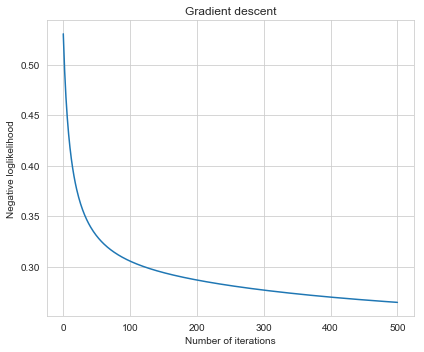

In [22]:
figure = plt.figure(figsize = (6, 5))
plt.plot(gd_loss, '-')
plt.title('Gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout()

### <font color=darkred> Stochastic gradient descent </font>

In [40]:
def sgd(model, w0, n_iter, step):  
    loss_val  = np.zeros(n_iter)
    w = w0.copy()
    n_samples = model.n_samples
    for idx in range(n_iter):
        i = np.random.randint(0, model.n_samples)
        w = w - step * model.grad_fi(i,w) / (np.sqrt(idx + 1))
        loss_val[idx] = model.loss(w)
    return w, loss_val

In [46]:
step_sgd = 1e-1
n_iter_max = 500

w, sgd_loss = sgd(model, w0, n_iter_max, step_sgd)

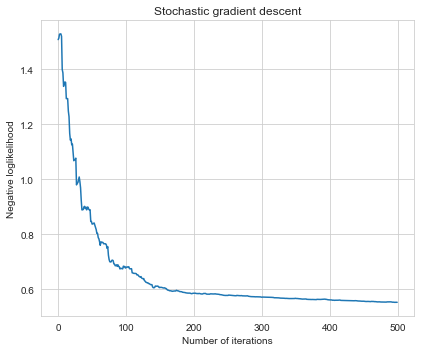

In [35]:
figure = plt.figure(figsize = (6, 5))
plt.plot(sgd_loss, '-')
plt.title('Stochastic gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout()

### <font color=darkred> Coordinate gradient descent </font>

In [42]:
def cgd(model, w0, n_iter, step):
    w = w0.copy()
    loss_val  = np.zeros(n_iter+1)
    n_features = model.n_features
    for k in range(n_iter + 1):
        for j in range(n_features):
            w[j] = w[j]-step*model.grad_coordinate(j,w)
        loss_val[k] = model.loss(w)
    return w, loss_val

In [47]:
step_cgd = 1e-1
n_iter_max = 500

w, cgd_loss = sgd(model, w0, n_iter_max, step_cgd)

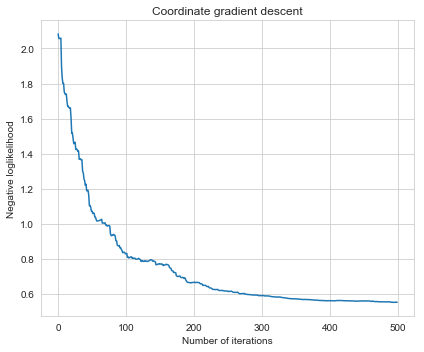

In [38]:
figure = plt.figure(figsize = (6, 5))
plt.plot(cgd_loss, '-')
plt.title('Coordinate gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout()

### <font color=darkred> All together </font>

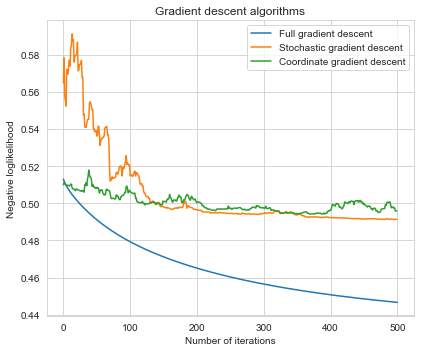

In [48]:
figure = plt.figure(figsize = (6, 5))
plt.plot(gd_loss, '-', label = 'Full gradient descent')
plt.plot(sgd_loss, '-', label = 'Stochastic gradient descent')
plt.plot(cgd_loss, '-', label = 'Coordinate gradient descent')
plt.title('Gradient descent algorithms')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.legend()
plt.tight_layout()

### <font color=darkred> Performance analysis </font>

Compare the minimizers you obtain using the different algorithms, with a large and a small number of iterations. This can be done with `plt.stem` plots.

Analyze the influence of the correlation of the features on the performance of the optimization algorithms. 

Analyze the influence of $\lambda$ on the performance of the optimization algorithms. 